In [373]:
# работа с данными
import numpy as np
import pandas as pd

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")


# machine learning
from sklearn.model_selection import train_test_split,  GridSearchCV

from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# Отображаем все столбцы в датасете
pd.set_option("display.max_columns", None )

In [332]:
# Loading the dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# Target
Transported = df_train['Transported'].to_numpy()
# drop target from df_train
df_train.drop('Transported', axis=1, inplace=True)
# concat train and test
dataset = pd.concat([df_train, df_test], sort= True)
# make copy
df = dataset.copy()
# List of dataframes
dfs = [df_train, df_test]
# Give names to each dataframe
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df.name = 'All Set'


In [333]:
print('Количество обучающих объектов = {}'.format(df_train.shape[0]))
print('Количество тестовых объектов = {}\n'.format(df_test.shape[0]))
print('Размерность обучающих данных (X Shape) = {}'.format(df_train.shape))
print('Размерность целевой переменной (y Shape) = {}\n'.format(Transported.shape[0]))
print('Размерность тестовая данных (X Shape) = {}'.format(df_test.shape))
print('Размерность целевой переменной теста (y Shape) = {}\n'.format(df_test.shape[0]))

print('df_train.columns\n', df_train.columns.to_list())
print('df_test.columns\n', df_test.columns.to_list())

Количество обучающих объектов = 8693
Количество тестовых объектов = 4277

Размерность обучающих данных (X Shape) = (8693, 13)
Размерность целевой переменной (y Shape) = 8693

Размерность тестовая данных (X Shape) = (4277, 13)
Размерность целевой переменной теста (y Shape) = 4277

df_train.columns
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']
df_test.columns
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


## Анализ данных

* `PassengerId` — уникальный идентификатор для каждого пассажира. 
Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, 
с которой путешествует пассажир, а pp — его номер в группе. 
Люди в группе часто являются членами семьи, но не всегда.

* `HomePlanet` — планета, с которой вылетел пассажир, обычно планета его постоянного проживания.

* `CryoSleep` — указывает, выбрал ли пассажир режим анабиоза на время путешествия. 
Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.

* `Cabin` — номер каюты, в которой находится пассажир. 
Принимает форму палуба/число/сторона, где сторона может быть либо P для левого борта, 
либо S для правого борта.

* `Destination` — планета, на которую будет высаживаться пассажир.

* `Age` - возраст пассажира.

* `VIP` - оплатил ли пассажир специальное VIP-обслуживание во время рейса.

* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` — сумма, которую пассажир выставил в счет 
за каждое из многочисленных роскошных удобств космического корабля «Титаник».

* `Name` - Имя и фамилия пассажира.

* `Transported` — был ли пассажир перенесен в другое измерение. Это цель, столбец, 
который вы пытаетесь предсказать.

In [334]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} Количество пропущенных значений: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
display_missing(df)

Age Количество пропущенных значений: 270
Cabin Количество пропущенных значений: 299
CryoSleep Количество пропущенных значений: 310
Destination Количество пропущенных значений: 274
FoodCourt Количество пропущенных значений: 289
HomePlanet Количество пропущенных значений: 288
Name Количество пропущенных значений: 294
PassengerId Количество пропущенных значений: 0
RoomService Количество пропущенных значений: 263
ShoppingMall Количество пропущенных значений: 306
Spa Количество пропущенных значений: 284
VIP Количество пропущенных значений: 296
VRDeck Количество пропущенных значений: 268




# Пропущенные значения

## Cabin

In [335]:
# Создадим новую колонку с палубой, где из колонки Cabin возьмём первый символ, где каюта не указана - ставим 'M'
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
# Удаляем измененную колонку
df.drop(['Cabin'], inplace=True, axis=1)
# Переместим пассажиров из палубы Т на палубу А
df['Deck'] = np.where((df['Deck'] == 'T'), 'A', df['Deck'])
# Encoding
df = pd.get_dummies(data = df, columns=['Deck'])

## Age

In [336]:
# Заполняем пропущенные значения по медиане
print('Медианный возраст всех пассажиров: {}'.format(df['Age'].median()))
df['Age'] = df['Age'].fillna(df['Age'].median())

Медианный возраст всех пассажиров: 27.0


## CryoSleep

In [337]:
# Переводим колонку CryoSleep в бинарный вид
df['CryoSleep'] = np.where((df['CryoSleep'] == True), 1, df['CryoSleep'])
df['CryoSleep'] = np.where((df['CryoSleep'] == False), 0, df['CryoSleep'])
# Смотрим популярное значение
df['CryoSleep'].value_counts()


0    8079
1    4581
Name: CryoSleep, dtype: int64

In [338]:
# заполняем NaN
df['CryoSleep'] = df['CryoSleep'].fillna(0)
# Encoding
df = pd.get_dummies(data = df, columns=['CryoSleep'])

## Destination

In [339]:
# Смотрим популярное значение
df['Destination'].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [340]:
# заполняем NaN
df['Destination'] = df['Destination'].fillna('TRAPPIST-1e')
# Encoding
df = pd.get_dummies(data = df, columns=['Destination'])

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [341]:
# заполняем NaN
df['RoomService'] = df['RoomService'].fillna(df['RoomService'].mean())
df['FoodCourt'] = df['FoodCourt'].fillna(df['FoodCourt'].mean())
df['ShoppingMall'] = df['ShoppingMall'].fillna(df['ShoppingMall'].mean())
df['Spa'] = df['Spa'].fillna(df['Spa'].mean())
df['VRDeck'] = df['VRDeck'].fillna(df['VRDeck'].mean())

## HomePlanet

In [342]:
# Смотрим популярное значение
df['HomePlanet'].value_counts()

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

In [343]:
# заполняем NaN
df['HomePlanet'] = df['HomePlanet'].fillna('Earth')

## VIP

In [344]:
# Смотрим популярное значение
df['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [345]:
# Переводим колонку CryoSleep в бинарный вид
df['VIP'] = np.where((df['VIP'] == True), 1, df['VIP'])
df['VIP'] = np.where((df['VIP'] == False), 0, df['VIP'])
# заполняем NaN
df['VIP'] = df['VIP'].fillna(0)
# Encoding
df = pd.get_dummies(data = df, columns=['VIP'])

## HomePlanet

In [346]:
# Encoding
df = pd.get_dummies(data = df, columns=['HomePlanet'])

## Passenger Id

In [347]:
# Encoding
df['group'] = [int(row.split('_')[0]) for row in df['PassengerId']]
df['number_in_group'] = [int(row.split('_')[1]) for row in df['PassengerId']]
df.drop('PassengerId',axis=1,inplace=True)

In [348]:
# Encoding
df = pd.get_dummies(data = df, columns=['number_in_group'])

In [349]:

def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} Количество пропущенных значений: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
display_missing(df)

Age Количество пропущенных значений: 0
FoodCourt Количество пропущенных значений: 0
Name Количество пропущенных значений: 294
RoomService Количество пропущенных значений: 0
ShoppingMall Количество пропущенных значений: 0
Spa Количество пропущенных значений: 0
VRDeck Количество пропущенных значений: 0
Deck_A Количество пропущенных значений: 0
Deck_B Количество пропущенных значений: 0
Deck_C Количество пропущенных значений: 0
Deck_D Количество пропущенных значений: 0
Deck_E Количество пропущенных значений: 0
Deck_F Количество пропущенных значений: 0
Deck_G Количество пропущенных значений: 0
Deck_M Количество пропущенных значений: 0
CryoSleep_0 Количество пропущенных значений: 0
CryoSleep_1 Количество пропущенных значений: 0
Destination_55 Cancri e Количество пропущенных значений: 0
Destination_PSO J318.5-22 Количество пропущенных значений: 0
Destination_TRAPPIST-1e Количество пропущенных значений: 0
VIP_0 Количество пропущенных значений: 0
VIP_1 Количество пропущенных значений: 0
HomePla

In [350]:
df.drop('Name',axis=1,inplace=True)

## Heat Map

In [353]:
TranspTarget = pd.DataFrame(Transported)
df_train = df.iloc[:8693].assign(TranspTarget=TranspTarget.values)
df_test = df.iloc[8693:]

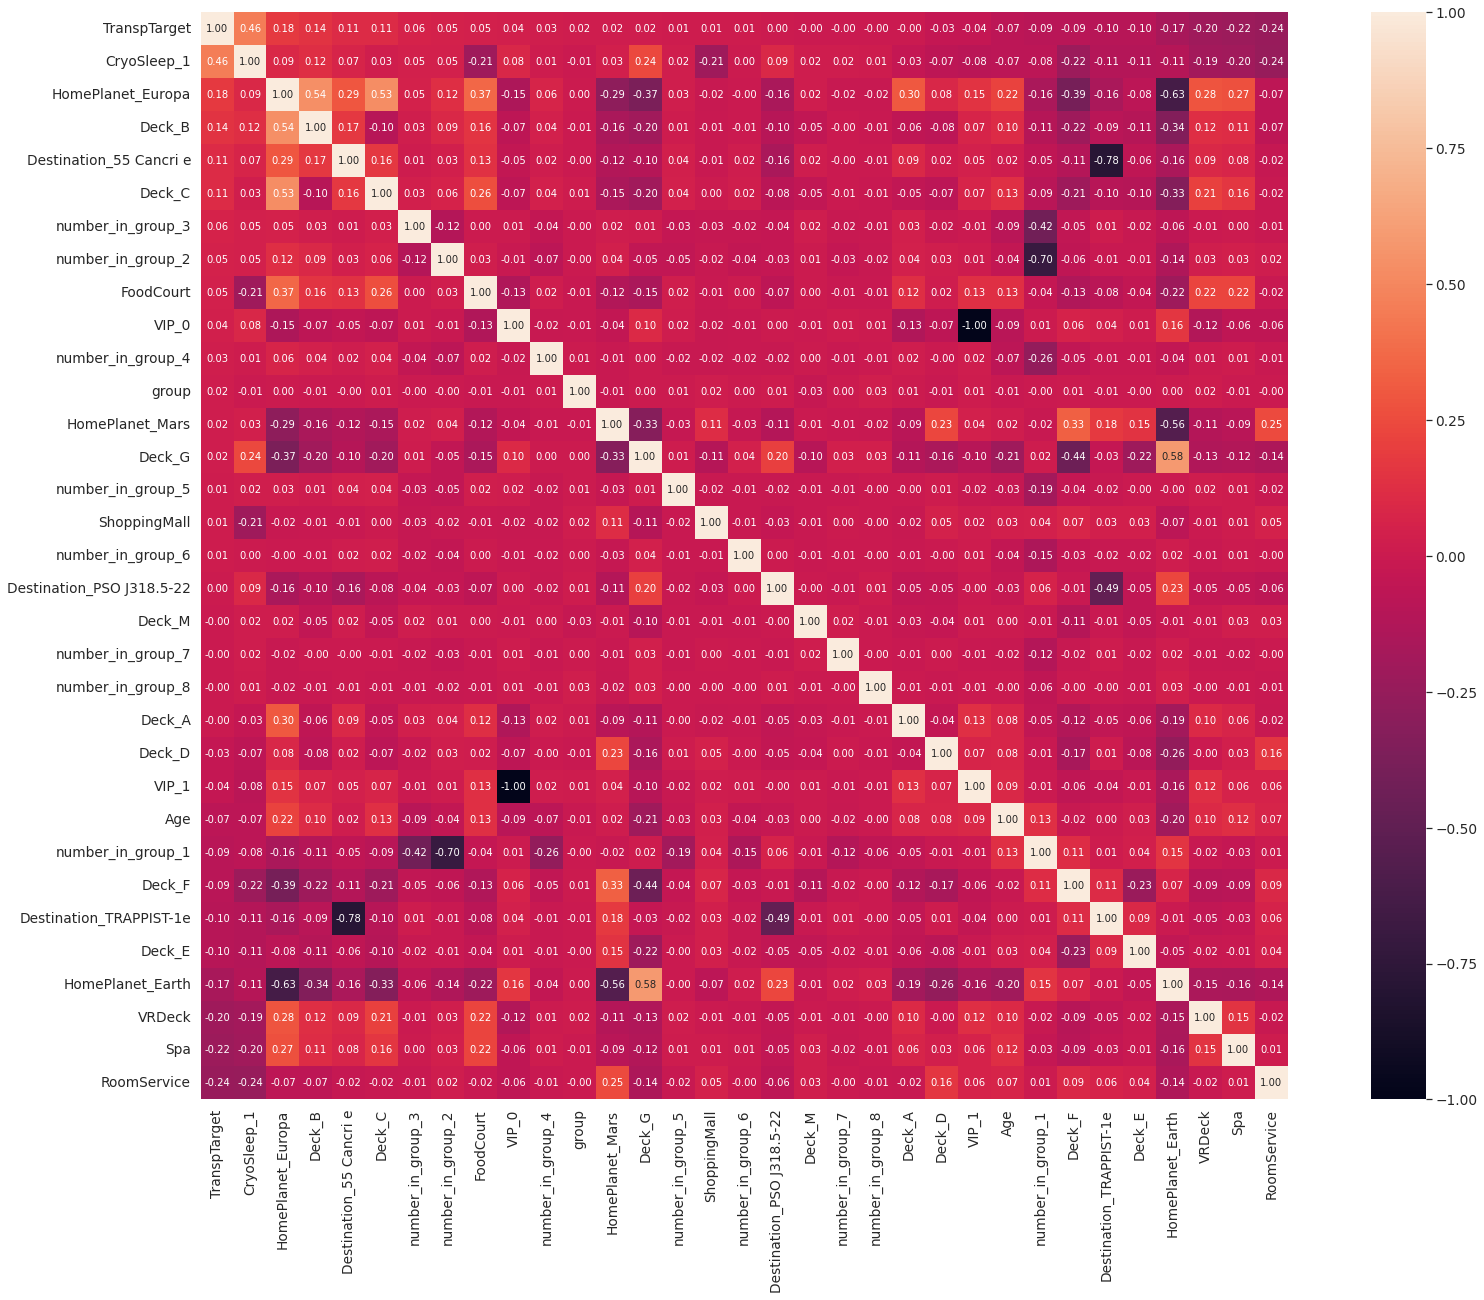

In [355]:
#saleprice correlation matrix
df_train = df_train.astype('float')
f, ax = plt.subplots(figsize=(30, 20))
corrmat = df_train.corr()
k = 33 #кол-во колонок
cols = corrmat.nlargest(k, 'TranspTarget')['TranspTarget'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

# Fit models

In [356]:
df_train.drop('TranspTarget',axis=1,inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(df_train, TranspTarget, random_state=23, test_size=0.2)

## RandomForestClassifier

In [378]:
clf = RandomForestClassifier()
params = {
    'n_estimators': np.array([100, 6000, 100]),
    'max_features': ['sqrt','log2'],
    'max_depth': np.array([3, 20, 1]),
    'min_samples_split': np.array([2,10,1])
}
cv = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5, 
                  n_jobs=4)

In [379]:
cv.fit(X_train, y_train)

/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: Dat

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': array([ 3, 20,  1]),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': array([ 2, 10,  1]),
                         'n_estimators': array([ 100, 6000,  100])},
             scoring='accuracy')

In [380]:
print(cv.best_score_)

0.8008344496221858


In [381]:
print(cv.best_params_)

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 6000}


In [383]:
rfc = RandomForestClassifier(max_depth = 20, max_features = 'sqrt', min_samples_split = 10, n_estimators = 6000)

In [384]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=6000)

In [386]:
print("train acc:", accuracy_score(rfc.predict(X_train), y_train))
print("test acc:", accuracy_score(rfc.predict(X_valid), y_valid))

train acc: 0.9142939315501869
test acc: 0.8021851638872916


In [388]:
predict_test = rfc.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred.csv')

## LogisticRegression

In [391]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print("train acc:", accuracy_score(lr.predict(X_train), y_train))
print("test acc:", accuracy_score(lr.predict(X_valid), y_valid))

train acc: 0.7745182628702905
test acc: 0.7987349051178838


In [392]:
predict_test = lr.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred_lr.csv')

## Random Forest with Scaler

In [393]:
df_train = StandardScaler().fit_transform(df_train)

In [395]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(df_train, TranspTarget, random_state=23, test_size=0.2)

In [397]:
clf = RandomForestClassifier()
params = {
    'n_estimators': np.array([100, 6000, 100]),
    'max_features': ['sqrt','log2'],
    'max_depth': np.array([3, 20, 1]),
    'min_samples_split': np.array([2,10,1])
}
cv1 = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5, 
                  n_jobs=4)

In [398]:
cv1.fit(X_train1, y_train1)

/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/tabaqui/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: Dat

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': array([ 3, 20,  1]),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': array([ 2, 10,  1]),
                         'n_estimators': array([ 100, 6000,  100])},
             scoring='accuracy')

In [399]:
print(cv1.best_score_)

0.8015534603230428


In [400]:
print(cv1.best_params_)

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 6000}


In [401]:
rfc1 = RandomForestClassifier(max_depth = 20, max_features = 'sqrt', min_samples_split = 10, n_estimators = 6000)

In [402]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=6000)

In [403]:
print("train acc:", accuracy_score(rfc.predict(X_train1), y_train1))
print("test acc:", accuracy_score(rfc.predict(X_valid1), y_valid1))

train acc: 0.5033074489502445
test acc: 0.4968372627947096


In [405]:
predict_test = rfc1.predict(df_test)
frame = pd.read_csv('sample_submission.csv', index_col='PassengerId')
frame['Transported'] = predict_test
frame.to_csv('kaggle_pred_scaler.csv')